<a href="https://colab.research.google.com/github/Nikelroid/DeepLearning_Project/blob/main/Phase-1/Phase1_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My Drive/

/content/drive/My Drive


In [ ]:
# !ls drive/My\ Drive/

In [ ]:
# !cp train_ende.zip .
# !cp test.zip .

In [ ]:
! git clone https://github.com/XL2248/

In [ ]:
!cp MSCTD/MSCTD_data/ende/english_*.txt .
!cp MSCTD/MSCTD_data/ende/image_index_*.txt .
!cp MSCTD/MSCTD_data/ende/sentiment_*.txt .

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
!gdown --id 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W


In [76]:
%%bash
for x in dataset/test/*.zip
do
  unzip -qq $x
done;

In [ ]:
!mkdir dataset
!cd dataset; mkdir train test dev

In [ ]:
# !mv --help

In [ ]:
!mv *train* dataset/train
!mv *test* dataset/test
!mv *dev* dataset/dev

In [ ]:
!ls dataset/train/train_ende | head

In [ ]:
!head dataset/train/english_train.txt

head: cannot open 'dataset/train/english_train.txt' for reading: No such file or directory


In [ ]:
!head dataset/train/sentiment_train.txt

head: cannot open 'dataset/train/sentiment_train.txt' for reading: No such file or directory


In [ ]:
!head dataset/train/image_index_train.txt

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16]
[17, 18, 19, 20, 21]
[22, 23, 24, 25, 26]
[27, 28, 29, 30, 31]
[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
[43, 44, 45, 46, 47, 48, 49, 50, 51]
[52, 53, 54, 55, 56, 57]
[58, 59, 60, 61, 62]


#Dataset and Dataloader

In [3]:
!pip install mtcnn
import torch
from torchvision import transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from PIL import Image
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import groupby
import seaborn as sns
import cv2
from mtcnn.mtcnn import MTCNN
# import linecache

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 68.8 MB/s eta 0:00:00


In [56]:
class MSCTD_Dataset (Dataset):
  def __init__(self, dataset_dir, images_dir, conversation_dir, texts, sentiments, transform=None):
    self.dataset_path = Path(dataset_dir)
    self.images_path = self.dataset_path / images_dir
    self.sentiment_path = self.dataset_path / sentiments
    self.text_path = self.dataset_path / texts
    self.conversations_path = self.dataset_path / conversation_dir

    self.transform = transform

    with open(self.sentiment_path, 'r') as f:
      self.length = len(f.readlines())

    with open(self.text_path, 'r') as f:
        self.texts = f.read().splitlines()

    with open(self.sentiment_path, 'r') as f:
        self.sentiments = np.array(f.read().splitlines()).astype("int32")
    
    with open(self.conversations_path, 'r') as f:
        self.conversations = np.array(f.read().splitlines())
    
  def __len__(self):
        return self.length

  def __getitem__(self, idx):
        img_path = self.images_path / f'{idx}.jpg'
        image = Image.open(img_path)
        # image = read_image(str(img_path))
        if self.transform:
            image = self.transform(image)
       
        #txt = self.texts[idx].strip()
        
        sentiment = self.sentiments[idx]


        return image,sentiment

In [9]:
class Face_Dataset(Dataset):
  def __init__(self, path,trasnform):
    self.path = path
    self.transform = transform
    image_lenght = int(len([name for name in os.listdir(self.path) if os.path.isfile(os.path.join(self.path, name))])/2)
    
    self.images = []
    self.labels = []
    print(image_lenght,"Package of images and label found in",self.path)
    from tqdm import tqdm
    for p in range (image_lenght):
      with open(self.path+"/pack"+str(p)+".txt", "rb") as fp:   
        self.images += pickle.load(fp)
      with open(self.path+"/labels"+str(p)+".txt", "rb") as fp:   
        self.labels += pickle.load(fp)
    
  def __len__(self):
    if len(self.images) == len(self.labels):
        return len(self.images)
    else :
        print("Error in loading and fetch data!")
        pass

  def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        sentiment = self.labels[idx] 
        return image,sentiment

In [ ]:
trainset = MSCTD_Dataset('dataset/train', 'train_ende', 'image_index_train.txt', 'english_train.txt', 'sentiment_train.txt')
#devset = MSCTD_Dataset('dataset/dev', 'train_ende', 'image_index_train.txt', 'english_train.txt', 'sentiment_train.txt')
testset = MSCTD_Dataset('dataset/test', 'test', 'image_index_test.txt', 'english_test.txt', 'sentiment_test.txt')



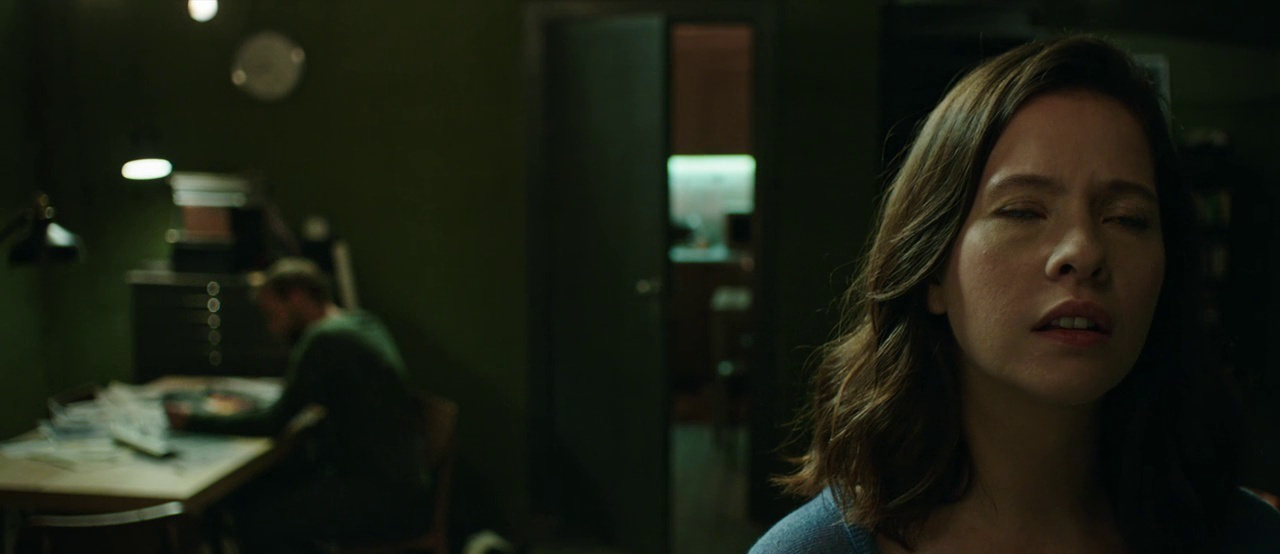

In [ ]:
text, image, sentiment = testset[6]
image

In [5]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from PIL import Image
from torch import nn
!pip install git+https://github.com/elliottzheng/face-detection.git@master
from skimage import io
from face_detection import RetinaFace
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/elliottzheng/face-detection.git (to revision master) to /tmp/pip-req-build-cy41k48w
  Running command git clone --filter=blob:none --quiet https://github.com/elliottzheng/face-detection.git /tmp/pip-req-build-cy41k48w
  Resolved https://github.com/elliottzheng/face-detection.git to commit 096cbf438dab07a313dac3044653d211725d64ba
  Preparing metadata (setup.py) ... done
  Created wheel for face-detection: filename=face_detection-1.0.5-py3-none-any.whl size=1638328 sha256=8e8896ab130474da45c821646eb7c7a6436923d4b729ba90c9c5207687163092
  Stored in directory: /tmp/pip-ephem-wheel-cache-dmimoc5v/wheels/99/88/1d/b1e416a6280864d3235db4c27ad9efd5eae332f5e8fbb2ff3a
Successfully built face-detection


In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


##loading and saving data of images and face sentiments:



In [187]:
transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Resize((288,288),transforms.InterpolationMode("bicubic"))
                                ,transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])      
image_trainset = MSCTD_Dataset('dataset/train', 'train_ende', 'image_index_train.txt', 'english_train.txt', 'sentiment_train.txt')
face_trainset = Face_Dataset('dataset/train/faces', transforms)
               
image_testset = MSCTD_Dataset('dataset/test', 'test', 'image_index_test.txt', 'english_test.txt', 'sentiment_test.txt')
face_testset = Face_Dataset('dataset/test/faces', transforms)

face_trainloader = torch.utils.data.DataLoader(face_trainset, batch_size=64, shuffle=False, num_workers=2)
face_testloader = torch.utils.data.DataLoader(face_testset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
!pip install git+https://github.com/elliottzheng/face-detection.git@master
from skimage import io
from face_detection import RetinaFace
from tqdm import tqdm
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
import pickle
import torchvision
from torchvision import transforms

In [194]:
class lastLayer(nn.Module):
    def __init__(self, pretrained):
        super(lastLayer, self).__init__()
        self.pretrained = pretrained
        self.last = nn.Sequential(
            nn.Dropout(p = 0.2,inplace=True),
            nn.Linear(1408, 90),
            nn.Dropout(p = 0.3,inplace=True),
            nn.Linear(90, 30),
            nn.Dropout(p = 0.1,inplace=True),
            nn.Linear(30, 3),
            )
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.last(x)
        return x

net = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
net.classifier = nn.Sequential()

net = lastLayer(net).to(device)

In [195]:
net.load_state_dict(torch.load("models/face_aug_modal.pth"))
net.eval()

lastLayer(
  (pretrained): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_

###Load and save faces_lengths

In [17]:
main_detector = RetinaFace(gpu_id=0)
def face_detector(image):
    faces_boundaries = main_detector(image)
    faces = []
    for i in range(len(faces_boundaries)):
      stats, _, score = faces_boundaries[i]
      stats = stats.astype(int)
      if score>0.95:
        faces.append(Image.fromarray(image[max(0,stats[1]):min(image.shape[0],stats[3]),
                                           max(0,stats[0]):min(image.shape[1],stats[2])]))
    return faces

In [ ]:
count = 0
len_faces_test = []
for img,_ in image_testset:
  count+=1
  len_faces_test.append(len(face_detector(np.array(img.convert('RGB')))))
  if count%1000==999:
    print(count)
with open("dataset/test/sents_data/len_faces.txt", 'wb') as f:
          pickle.dump(len_faces_test, f)

In [ ]:
len_faces = []
count=0
for img,_ in image_trainset:
  count+=1
  len_faces.append(len(face_detector(np.array(img.convert('RGB')))))
  if count%2000==1999:
    print(count)
with open("dataset/train/sents_data/len_faces.txt", 'wb') as f:
          pickle.dump(len_faces, f)

In [18]:
with open("dataset/train/sents_data/len_faces.txt", 'rb') as f:
        len_faces=pickle.load(f)

with open("dataset/test/sents_data/len_faces.txt", 'rb') as f:
        len_faces_test=pickle.load(f)

In [19]:
print(len(len_faces), len(len_faces_test))

20240 5067


###Compute and save faces_sentiments

In [20]:
def statical_random_generator(counter):
  r = np.random.random(1)
  if r<counter[0]:
    return [1,0,0]
  elif r<(counter[0]+counter[1]):
    return [0,1,0]
  else:
    return [0,0,1]

In [21]:
def predict_faces(faces_sents, len_faces, transform,counter):
  predictions = []
  indices = np.cumsum(len_faces)
  index = 0
  for i in indices:
    predictions.append(predict(faces_sents,index,i,counter))
    index = i
  with open("dataset/train/sents_data/predictions.txt", 'wb') as f:
          pickle.dump(predictions, f)
  with open("dataset/train/sents_data/face_indices.txt", 'wb') as f:
          pickle.dump(indices, f)
  return predictions
  

def predict(faces_sents , index, last,counter):
  if (index==last):
    return [1,0,0]
  predictions = faces_sents[index:last]
  if 1 in predictions and not  2 in predictions:
    return [0,1,0]
  elif 2 in predictions and not  1 in predictions:
    return [0,0,1]
  elif 2 in predictions and 1 in predictions:
    return statical_random_generator(counter)
  else:
    return [1,0,0]

In [22]:
faces_sents = torch.empty((1),device=device)
counter = [6/21,8/21,7/21]
transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Resize((288,288),transforms.InterpolationMode("bicubic"))
                                ,transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

with torch.no_grad(), tqdm(enumerate(face_trainloader), total=len(face_trainloader)) as pbar:
        for i, (x,y) in pbar:
            x = x.to(device).float()
            y = y.to(device).to(torch.int64)
            p = net(x).float()
            faces_sents = torch.cat((faces_sents,torch.argmax(p,1)),dim=0)
faces_sents = faces_sents[1:]
with open("dataset/train/sents_data/face_sents.txt", 'wb') as f:
          pickle.dump(faces_sents, f)

100%|██████████| 366/366 [02:11<00:00,  2.79it/s]


In [118]:
faces_sents.size()

torch.Size([23363])

In [23]:
faces_sents_test = torch.empty((1),device=device)
transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Resize((288,288),transforms.InterpolationMode("bicubic"))
                                ,transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

with torch.no_grad(), tqdm(enumerate(face_testloader), total=len(face_testloader)) as pbar:
        for i, (x,y) in pbar:
            x = x.to(device).float()
            y = y.to(device).to(torch.int64)
            p = net(x).float()
            faces_sents_test = torch.cat((faces_sents,torch.argmax(p,1)),dim=0)
faces_sents_test = faces_sents_test[1:]
with open("dataset/test/sents_data/face_sents.txt", 'wb') as f:
          pickle.dump(faces_sents_test, f)

100%|██████████| 185/185 [00:33<00:00,  5.44it/s]


In [ ]:
# with open("dataset/test/sents_data/face_sents.txt", 'rb') as f:
#           faces_sents = pickle.load(f)
# with open("dataset/train/sents_data/face_sents.txt", 'rb') as f:
#           faces_sents_test = pickle.load(f)

In [24]:
predictions = torch.tensor(predict_faces(faces_sents, len_faces, transform,counter),device=device)
test_predictions = torch.tensor(predict_faces(faces_sents_test, len_faces_test, transform,counter),device=device)

In [28]:
# with open("dataset/train/sents_data/predictions.txt", 'wb') as f:
#           pickle.dump(predictions, f)
# with open("dataset/test/sents_data/predictions_test.txt", 'wb') as f:
#           pickle.dump(test_predictions, f)

###Compute and save sentiments related to the whole image

In [ ]:
class lastLayer(nn.Module):
    def __init__(self, pretrained):
        super(lastLayer, self).__init__()
        self.pretrained = pretrained
        self.last = nn.Sequential(
            nn.Dropout(p = 0.2,inplace=True),
            nn.Linear(1408, 90),
            nn.Dropout(p = 0.3,inplace=True),
            nn.Linear(90, 30),
            nn.Dropout(p = 0.1,inplace=True),
            nn.Linear(30, 3),
            )
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.last(x)
        return x



net = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
net.classifier = nn.Sequential()
net = lastLayer(net).to(device)
net.load_state_dict(torch.load("models/scene_modal_en.pth"))
net.eval()

In [192]:
transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Resize((288,288),transforms.InterpolationMode("bicubic"))
                                ,transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
image_testset = MSCTD_Dataset('dataset/test', 'test', 'image_index_test.txt', 'english_test.txt', 'sentiment_test.txt',transform)
#image_trainset = MSCTD_Dataset('dataset/train', 'train_ende', 'image_index_train.txt', 'english_train.txt', 'sentiment_train.txt',transform)

In [59]:
image_trainloader = torch.utils.data.DataLoader(image_trainset, batch_size=64, shuffle=False, num_workers=4)
images_sents = torch.empty((1),device=device)

with torch.no_grad(), tqdm(enumerate(image_trainloader), total=len(image_trainloader)) as pbar:
        for i, (x,y) in pbar:
            x = x.to(device).float()
            y = y.to(device).to(torch.int64)
            p = net(x).float()
            images_sents = torch.cat((images_sents,torch.argmax(p,1)),dim=0)
images_sents = images_sents[1:]
with open("dataset/train/sents_data/images_sents.txt", 'wb') as f:
          pickle.dump(images_sents, f)

100%|██████████| 317/317 [1:04:56<00:00, 12.29s/it]


In [196]:
image_testloader = torch.utils.data.DataLoader(image_testset, batch_size=64, shuffle=False, num_workers=4)
images_sents_test = torch.empty((1),device=device)

with torch.no_grad(), tqdm(enumerate(image_testloader), total=len(image_testloader)) as pbar:
        for i, (x,y) in pbar:
            
            x = x.to(device).float()
            y = y.to(device).to(torch.int64)
            p = net(x).float()
            images_sents_test = torch.cat((images_sents_test,torch.argmax(p,1)),dim=0)
images_sents_test = images_sents_test[1:]
with open("dataset/test/sents_data/images_sents.txt", 'wb') as f:
          pickle.dump(images_sents_test, f)

100%|██████████| 80/80 [15:15<00:00, 11.44s/it]


In [124]:
# with open("dataset/train/sents_data/images_sents.txt", 'rb') as f:
#           images_sents = pickle.load(f)
# with open("dataset/test/sents_data/image_sents.txt", 'rb') as f:
#           images_sents_test = pickle.load(f)

##training the mlp

In [197]:
class stablizer(nn.Module):
  def __init__(self):
    super(stablizer, self).__init__()
    self.fc = nn.Sequential(
        nn.Linear(7,20),
        nn.ReLU(),

        nn.Linear(20,10),
        nn.ReLU(),

        nn.Linear(10,3),
        nn.Softmax(dim=1)
    )
    
  def forward(self, x):
    output = self.fc(x)
    
    return output

In [106]:
def onehot(Y,num=3):
    out = torch.zeros((Y.size()[0],num),device=device)
    for i,index in enumerate(Y):
        out[i,index.item()] = 1
    return out 

In [200]:
from tqdm import tqdm
def train_epoch(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, input,labels,   accs_train ,loss_train):

    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.train()
    optimizer.zero_grad()

    x = input.float()
    y = labels.to(torch.int64)
    
    p = net(x).float()
    loss = criterion(p, y)
    epoch_loss += float(loss)
    predictions = p.argmax(-1)
    epoch_all += len(predictions)
    epoch_true += (predictions == y).sum()
    pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
      
    accs_train.append(float(epoch_true / epoch_all))
    loss_train.append(float(epoch_loss / (i + 1)))
    return accs_train,loss_train

def eval_epoch(net: nn.Module, criterion: nn.Module, input, labels,    accs_test ,loss_test ):

    epoch_loss = 0
    epoch_true = 0
    epoch_true_topfive = 0
    epoch_all = 0
    i = 0

    net.eval()

    x = input.float()
    y = labels.to(torch.int64)
    p = net(x).float()
    loss = criterion(p, y)
    epoch_loss += float(loss)

    # predict 
    predictions = p.argmax(-1)
    epoch_all += len(predictions)
    epoch_true += (predictions == y).sum()

    pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}% ')

    accs_test.append(float(epoch_true / epoch_all))
    loss_test.append(float(epoch_loss / (i + 1)))
    return accs_test,loss_test


In [199]:
input = torch.cat(((predictions, onehot(images_sents.reshape((-1,1)).to(torch.int)),torch.tensor(len_faces,device=device).reshape((-1,1)))),dim=1)
with open('dataset/train/sentiment_train.txt', 'r') as f:
        labels = torch.tensor(np.array(f.read().splitlines()).astype("int32"),device=device)
#train_dataloader = torch.utils.data.DataLoader(TensorDataset(input,labels), batch_size=1, shuffle=False, num_workers=2)

input_test = torch.cat(((test_predictions, onehot(images_sents_test.reshape((-1,1)).to(torch.int)),torch.tensor(len_faces_test,device=device).reshape((-1,1)))),dim=1)
with open('dataset/test/sentiment_test.txt', 'r') as f:
        labels_test = torch.tensor(np.array(f.read().splitlines()).astype("int32"),device=device)
# test_dataloader = torch.utils.data.DataLoader(TensorDataset(input_test,torch.tensor(labels_test,device=device)), batch_size=64, shuffle=False, num_workers=2)

In [ ]:
#next(iter(train_dataloader))

In [204]:
net = stablizer().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

from time import time

accs_train = []
loss_train = []
accs_test = []
loss_test = []
epochs = 6000

Epoch 3000 finished in 0.00s
Epoch 6000 finished in 0.00s


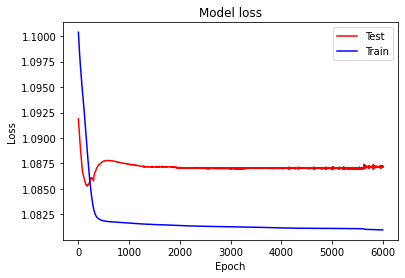

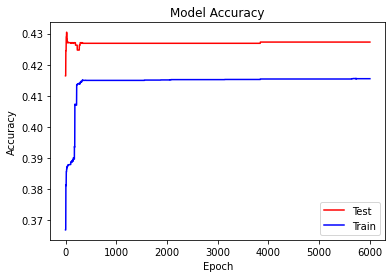

Best Accuracy :43.04%


In [205]:
for e in range(epochs):
    start_time = time()
    accs_train,loss_train = train_epoch(net, criterion, optimizer, input, labels,accs_train,loss_train)
    accs_test,loss_test = eval_epoch(net, criterion, input_test, labels_test,accs_test,loss_test)
    if accs_test[-1]==max(accs_test):
      torch.save(net.state_dict(), 'final_combinator.pth')
    end_time = time()
    if e%3000 == 2999:
      print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

plt.plot(np.array(loss_test), 'r')
plt.plot(np.array(loss_train), 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('loss4.jpg')
plt.show()

plt.plot(np.array(accs_test), 'r')
plt.plot(np.array(accs_train), 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('acc4.jpg')
plt.show()


print(f'Best Accuracy :{max(accs_test) * 100.:.2f}%')

##Construction:

In [203]:
class Image_sent_classifier(nn.Module):
  def __init__(self, retina, imagenet, facenet, combiner):
    super(Image_sent_classifier,self).__init__()
    self.retina = retina
    self.imagenet = imagenet
    self.facenet = facenet
    self.combiner = combiner

  def forward(self, input):
    input_faces = self.retina(input)
    first_input = self.faces_net(input_faces)
    first_input = torch.tensor(predict(first_input, 0, len(final_input),[6/21,7/21,8/21]),device=device)
    first_input = torch.argmax(first_input,1)

    second_input = self.imagenet(input)
    second_input = torch.argmax(second_input,1)

    third_input = len(input_faces)

    final_input = torch.cat((onehot(first_input.reshape((-1,1))).to(device), onehot(torch.tensor(second_input.reshape((-1,1)))).to(device),torch.tensor(third_input,device)),dim=1)

    output = self.combiner(final_input)

    return torch.argmax(output,dim=-1)